In [67]:
import io
import base64

import pandas as pd
import numpy as np
from pyproj import CRS, Transformer
from matplotlib.image import imsave

from skgstat import Variogram, OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv('coords.csv')

crs_4326 = CRS('epsg:4326')
crs_proj = CRS('epsg:32143')
transformer = Transformer.from_crs(crs_4326, crs_proj)
pts = [(lat, lon) for lat, lon in zip(df.lat.values, df.lon.values)]
pts_proj = transformer.itransform(pts)
pts_proj = [pt for pt in pts_proj]
df['x'] = [pt[0]for pt in pts_proj]
df['y'] = [pt[1] for pt in pts_proj]


In [69]:
bounds = [[41.396185, -112.668707], [39.906272, -111.169071]]

In [70]:
region = [39.906272, -112.668707, 41.396185, -111.169071]
df_region = df.loc[(df['lat'] > region[0]) & (df['lat'] < region[2]) & (df['lon'] > region[1]) & (df['lon'] < region[3])]
df_region


,lat,lon,value,x,y
0,40.507316,-111.899188,13.19,466166.609997,2.241435e+06
1,40.727510,-111.861434,10.27,469465.258255,2.265873e+06
2,41.237524,-111.971543,4.01,460461.709717,2.322560e+06
4,40.696268,-111.877378,15.11,468103.643742,2.262409e+06
5,40.757155,-111.789128,4.13,475584.446537,2.269143e+06
...,...,...,...,...,...
433,41.192739,-111.943092,6.51,462822.626546,2.317573e+06
434,40.694588,-111.960084,17.32,461112.348504,2.262255e+06
435,40.690900,-111.791479,1.75,475361.938825,2.261786e+06
436,40.779480,-111.875565,8.92,468295.680433,2.271649e+06


In [81]:
# PUT the target CRS here, where kriging will work for you
CRS_code = 32143
# Additionally specify the variogram and kriging parameters here
VARIO = dict(
    n_lags=100,
    estimator='matheron',
    model='exponential',
    # normalize=True
)
KRIG = dict(
    min_points=2,
    max_points=30
)
# specify the number of cells in each dimension
GRIDSIZE = 200
# alternatively, you can change the algorithm directly in the process function

In [82]:
def get_data(fname):
    df = pd.read_csv(fname)
    region = [39.906272, -112.668707, 41.396185, -111.169071]
    df = df.loc[(df['lat'] > region[0]) & (df['lat'] < region[2]) & (df['lon'] > region[1]) & (df['lon'] < region[3])]
    crs_4326 = CRS('epsg:4326')
    crs_proj = CRS('epsg:' + str(CRS_code))
    transformer = Transformer.from_crs(crs_4326, crs_proj)
    pts = [(lat, lon) for lat, lon in zip(df.lat.values, df.lon.values)]
    pts_proj = transformer.itransform(pts)
    pts_proj = [pt for pt in pts_proj]
    df['y'] = [pt[0]for pt in pts_proj]
    df['x'] = [pt[1] for pt in pts_proj]    

    return df
def variogram(df, **kwargs):
    # load data
    coords = df[['x', 'y']].values
    values = df.value.values

    return Variogram(coords, values, **kwargs)

def get_bounds(df):
    # get the bounds
    xmin = df.x.min()
    xmax = df.x.max()
    ymin = df.y.min()
    ymax = df.y.max()

    return xmin, xmax, ymin, ymax

def build_grid(df, resolution=100):
    xmin, xmax, ymin, ymax = get_bounds(df)
    xx, yy = np.mgrid[xmin:xmax:resolution*1j, ymin:ymax:resolution*1j]

    return xx, yy

def krig(vario, grid, **kwargs):
    # get the grid
    xx, yy = grid

    ok = OrdinaryKriging(vario, **kwargs)
    field = ok.transform(xx.flatten(), yy.flatten())
    sigma = ok.sigma

    return field.reshape(xx.shape), sigma.reshape(xx.shape)

def asBase64(field, name):
    f = io.BytesIO()

    vmin = 1.02 * np.nanmin(field)
    vmax = .98 * np.nanmax(field)
    imsave(f, np.fliplr(field), vmin=vmin, vmax=vmax, cmap='YlOrRd')

    f.seek(0)
    s = base64.b64encode(f.read())
    return 'data:image/png;base64,%s' % s.decode()

In [83]:
df = get_data('coords.csv')

grid = build_grid(df, GRIDSIZE)
V = variogram(df, normalize=False, **VARIO)
print('variogram found')
field, sigma = krig(V, grid, **KRIG)
print('kringing done')
data = asBase64(field, 'field.png')
# get the data bounds
bounds = [[df.lat.max(), df.lon.min()], [df.lat.min(), df.lon.max()]]

variogram found
kringing done


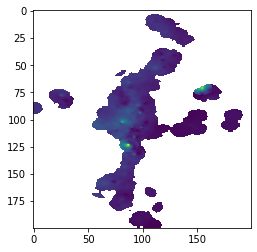

In [84]:
plt.imshow(field)

"var img = '';\nvar bnd = [[41.384924, -112.467771], [39.961038, -111.179579]];"
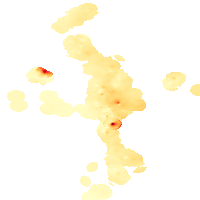

In [85]:
import json
code = "var img = '%s';\nvar bnd = %s;" % (data, json.dumps(bounds))
code